In [ ]:
min_lon = -74.2591   
min_lat = 40.4774    
max_lon = -73.7004   
max_lat = 40.9176    


In [ ]:
import ee


ee.Authenticate()  # Authenticate using the credentials in your browser
ee.Initialize()

# Define a smaller area of interest (AOI) with specific coordinates (smaller region)
min_lon = -74.2591   # Example coordinates for New York City
min_lat = 40.4774
max_lon = -73.7004
max_lat = 40.9176

# Define the AOI geometry using the coordinates
aoi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

# Specify the satellite image collection (e.g., Landsat 8 SR)
collection = ee.ImageCollection("NASA/HLS/HLSL30/v002")
collection = collection.filterBounds(aoi).filterDate('2019-01-01', '2020-12-31')

# Select bands (e.g., NIR, Red, Green for vegetation)
image = collection.select(['B5', 'B4', 'B3']).median().clip(aoi)

# Ensure the AOI is correctly handled and create a bounding box
region = aoi.bounds()

# Increase scale to reduce resolution (e.g., 60 meters instead of 30 meters)
download_url = image.getDownloadURL({
    'scale': 60,  # Increase scale to reduce resolution and file size
    'region': region,  # Use bounds() to make sure it's correctly formatted
    'fileFormat': 'GeoTIFF'
})

print("Download link:", download_url)


Download link: https://earthengine.googleapis.com/v1/projects/766006686557/thumbnails/0194597225df5e63fc48612a657f6e08-528e0a240a21861b0280ed8285e1ebc7:getPixels


In [24]:
!pip install rasterio numpy scikit-learn matplotlib


  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached scipy-1.14.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.4 MB ? eta -:--:--
   - -------------------------------------- 1.0/25.4 MB 3.0 MB/s eta 0:00:09
   -- ------------------------------------- 1.8/25.4 MB 3.4 MB/s eta 0:00:08
   ---- ----------------------------------- 2.9/25.4 MB 3.6 MB/s eta 0:00:07
   ----- ---------------------------------- 3.7/25.4 MB 3.8 MB/s eta 0:00:06
   ----- --

In [25]:
import rasterio
import numpy as np

# Load the images (B3, B4, B5)
band_b3 = rasterio.open('download.B3.tif').read(1)  # Band 3 (Green)
band_b4 = rasterio.open('download.B4.tif').read(1)  # Band 4 (Red)
band_b5 = rasterio.open('download.B5.tif').read(1)  # Band 5 (Near-Infrared)

# Stack the bands to create a multi-band image
image = np.stack([band_b3, band_b4, band_b5], axis=-1)


In [26]:
# Normalize the data
image_normalized = image / np.max(image)  # Normalize to range [0, 1]

# Reshape the image into a 2D array for classification
pixels = image_normalized.reshape((-1, 3))  # Each pixel is a 3-element vector (B3, B4, B5)


In [27]:
# Example: Manually create labels (0=water, 1=vegetation, 2=urban)
# You should replace this with real labeled data from your own dataset
labels = np.random.choice([0, 1, 2], size=pixels.shape[0])

# Now you have labeled data, where 'labels' corresponds to each pixel's class


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.2, random_state=42)

# Train the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = classifier.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.33


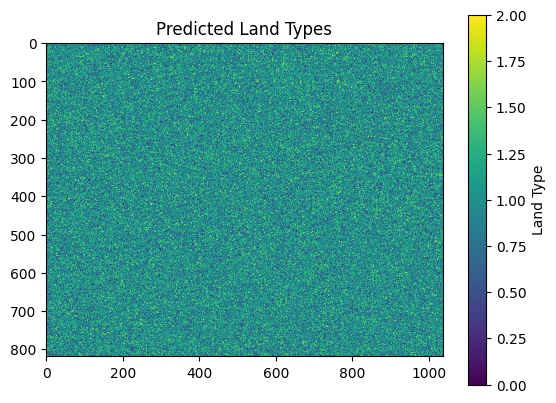

In [29]:
# Predict land types for all pixels in the image
predicted_labels = classifier.predict(pixels)

# Reshape the predictions back to the original image shape
predicted_image = predicted_labels.reshape(band_b3.shape)

# Visualize the classification result (optional)
import matplotlib.pyplot as plt

plt.imshow(predicted_image, cmap='viridis')
plt.colorbar(label='Land Type')
plt.title('Predicted Land Types')
plt.show()


In [30]:
from rasterio.enums import Resampling

# Define the output file path
output_path = 'predicted_land_types.tif'

# Open the metadata from the original image for creating the output file
with rasterio.open('download.B3.tif') as src:
    meta = src.meta

# Update the metadata to reflect the number of bands in the output
meta.update(count=1)

# Write the predicted image to a new file
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(predicted_image, 1)


In [ ]:
!pip install xxx